In [1]:
# prompt: 下载下面没有的库
# import pandas as pd
# import numpy as np
# import torch
# import networkx as nx
# import matplotlib.pyplot as plt
# import requests
# from bs4 import BeautifulSoup
# import re
# from transformers import AutoTokenizer, AutoModel
# from sklearn.metrics.pairwise import cosine_similarity

!pip install pandas numpy torch networkx matplotlib requests beautifulsoup4 transformers scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 44.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [7]:
import cudf
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt


In [9]:
# 读取 CSV 数据到 GPU DataFrame
nasdaq_df = cudf.read_csv('/content/merged_indices_2025-03-10.csv')
low_price_df = cudf.read_csv('/content/final_union_by_ticker.csv')

# 选择关键字段，并删除 description 列为空的记录
nasdaq_df = nasdaq_df[['ticker', 'description', 'sic_code', 'market_cap']].dropna(subset=['description'])
low_price_df = low_price_df[['ticker', 'description', 'sic_code', 'market_cap']].dropna(subset=['description'])

# 关键修复: 确保 ticker 列不包含 None 值
nasdaq_df = nasdaq_df.dropna(subset=['ticker'])
low_price_df = low_price_df.dropna(subset=['ticker'])

# 添加数据来源标记
nasdaq_df['source'] = 'nasdaq100'
low_price_df['source'] = 'lowprice'

# 合并数据集
combined_df = cudf.concat([nasdaq_df, low_price_df], ignore_index=True)

###########################
# 2. 使用 Hugging Face 模型生成文本嵌入
###########################
# 加载预训练模型和 Tokenizer，例如使用 bert-base-uncased 模型
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.eval()  # 设置为评估模式

# 如果希望利用 GPU 加速，确保将模型转移到 CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [10]:
def get_sentence_embedding(text):
    """
    利用BERT模型对输入文本进行编码，并采用平均池化得到句子向量
    """
    # 确保输入文本是字符串类型
    if not isinstance(text, str):
        text = str(text)

    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=128, padding=True)
    # 将 inputs 转移到 GPU
    inputs = {key: value.to(device) for key, value in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    # outputs.last_hidden_state shape: (batch_size, seq_len, hidden_size)
    embeddings = outputs.last_hidden_state
    attention_mask = inputs['attention_mask']
    # 计算每个token的权重后取平均池化
    mask = attention_mask.unsqueeze(-1).expand(embeddings.size()).float()
    masked_embeddings = embeddings * mask
    summed = torch.sum(masked_embeddings, dim=1)
    counts = torch.clamp(mask.sum(dim=1), min=1e-9)
    mean_pooled = summed / counts
    return mean_pooled.squeeze().cpu().numpy()

# 注意：使用 .to_arrow().to_pylist() 来将描述转换为 Python 列表
descriptions = combined_df['description'].to_arrow().to_pylist()

# 对所有描述进行嵌入，并添加进度条
embeddings = []
for text in tqdm(descriptions, desc="Embedding descriptions"):
    try:
        embedding = get_sentence_embedding(text)
        embeddings.append(embedding)
    except Exception as e:
        print(f"Error embedding text: {text[:50]}... - {str(e)}")
        # 使用零向量替代出错的情况
        embedding_dim = 768  # BERT base dimension
        embeddings.append(np.zeros(embedding_dim))

embeddings = np.vstack(embeddings)

# 计算文本描述的余弦相似度矩阵
text_sim_matrix = cosine_similarity(embeddings)

###########################
# 3. 构建多维度相似度矩阵
###########################
num_companies = combined_df.shape[0]
multi_sim_matrix = np.zeros((num_companies, num_companies))

# 权重设置：文本权重、SIC权重、市值权重（可根据需要调整）
w_text = 0.7
w_sic  = 0.2
w_market = 0.1

# 将 combined_df 转换为 Pandas DataFrame 操作
combined_df_pd = combined_df.to_pandas()

# 市值归一化处理
combined_df_pd['market_cap'] = pd.to_numeric(combined_df_pd['market_cap'], errors='coerce')
market_cap = combined_df_pd['market_cap'].fillna(0).values
max_cap = market_cap.max() if market_cap.max() > 0 else 1
market_cap_norm = market_cap / max_cap

# 确保 SIC 代码为数值类型，并处理缺失值
combined_df_pd['sic_code'] = pd.to_numeric(combined_df_pd['sic_code'], errors='coerce')

# 构建综合相似度矩阵
for i in tqdm(range(num_companies), desc="Constructing similarity matrix"):
    for j in range(i+1, num_companies):
        # 1. 文本相似度
        sim_text = text_sim_matrix[i, j]

        # 2. SIC 相似度：若相同，则设为1，否则0
        # 处理 NaN 值情况
        sic_i = combined_df_pd.iloc[i]['sic_code']
        sic_j = combined_df_pd.iloc[j]['sic_code']
        if pd.isna(sic_i) or pd.isna(sic_j):
            sim_sic = 0
        else:
            sim_sic = 1 if sic_i == sic_j else 0

        # 3. 市值相似度：差值越小，相似度越高
        diff = abs(market_cap_norm[i] - market_cap_norm[j])
        sim_market = 1 - diff

        # 仅考虑不同来源的公司之间（也可根据需求调整）
        if combined_df_pd.iloc[i]['source'] != combined_df_pd.iloc[j]['source']:
            combined_sim = w_text * sim_text + w_sic * sim_sic + w_market * sim_market
            multi_sim_matrix[i, j] = combined_sim
            multi_sim_matrix[j, i] = combined_sim

Constructing similarity matrix: 100%|██████████| 3159/3159 [13:23<00:00,  3.93it/s] 


Adding graph edges: 100%|██████████| 3159/3159 [09:54<00:00,  5.31it/s] 


图网络信息: 节点数量 = 3159, 边的数量 = 430955

前 20 个最强关系:
1. VRTX (nasdaq100) - VYNE (lowprice): 相似度 = 0.967
2. LULU (nasdaq100) - UAA (lowprice): 相似度 = 0.967
3. LULU (nasdaq100) - UA (lowprice): 相似度 = 0.967
4. VRTX (nasdaq100) - SKYE (lowprice): 相似度 = 0.964
5. REGN (nasdaq100) - ALDX (lowprice): 相似度 = 0.964
6. CEG (nasdaq100) - AMPS (lowprice): 相似度 = 0.963
7. VRTX (nasdaq100) - BTAI (lowprice): 相似度 = 0.962
8. VRTX (nasdaq100) - AUPH (lowprice): 相似度 = 0.962
9. VRTX (nasdaq100) - AVTX (lowprice): 相似度 = 0.962
10. VRTX (nasdaq100) - MTVA (lowprice): 相似度 = 0.962
11. VRTX (nasdaq100) - ERAS (lowprice): 相似度 = 0.962
12. VRTX (nasdaq100) - ZVSA (lowprice): 相似度 = 0.961
13. VRTX (nasdaq100) - LIPO (lowprice): 相似度 = 0.960
14. VRTX (nasdaq100) - TNGX (lowprice): 相似度 = 0.960
15. VRTX (nasdaq100) - NRXP (lowprice): 相似度 = 0.960
16. VRTX (nasdaq100) - ABEO (lowprice): 相似度 = 0.960
17. VRTX (nasdaq100) - ELDN (lowprice): 相似度 = 0.960
18. VRTX (nasdaq100) - NRXPW (lowprice): 相似度 = 0.960
19. MU (nasdaq100) - GSIT (lo

<ipython-input-13-a867a4a8bd0d>:104: UserWarning: Glyph 32435 (\N{CJK UNIFIED IDEOGRAPH-7EB3}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-13-a867a4a8bd0d>:104: UserWarning: Glyph 26031 (\N{CJK UNIFIED IDEOGRAPH-65AF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-13-a867a4a8bd0d>:104: UserWarning: Glyph 36798 (\N{CJK UNIFIED IDEOGRAPH-8FBE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-13-a867a4a8bd0d>:104: UserWarning: Glyph 20811 (\N{CJK UNIFIED IDEOGRAPH-514B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-13-a867a4a8bd0d>:104: UserWarning: Glyph 20844 (\N{CJK UNIFIED IDEOGRAPH-516C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-13-a867a4a8bd0d>:104: UserWarning: Glyph 21496 (\N{CJK UNIFIED IDEOGRAPH-53F8}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-13-a867a4a8bd0d>:104: UserWarning: Glyph 19982 (\N{CJK UNIFIED IDEOGRAPH-4E0E}) missi

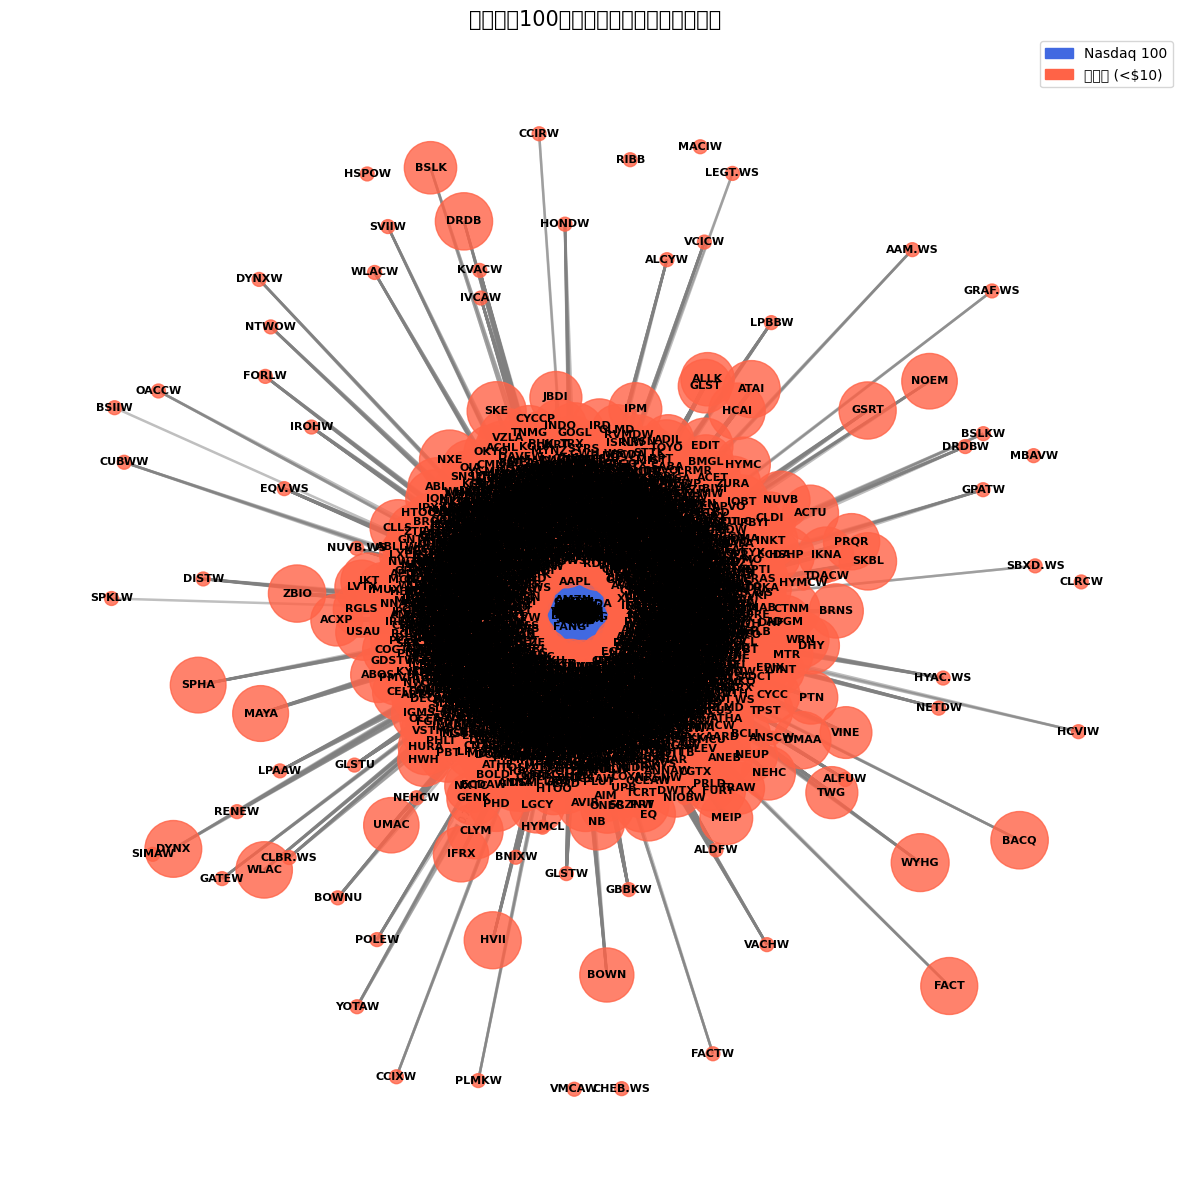


网络中心性分析:
度中心性最高的节点:
DHR: 0.9316 (nasdaq100)
GFS: 0.9275 (nasdaq100)
PLD: 0.9272 (nasdaq100)
TMO: 0.9269 (nasdaq100)
GEHC: 0.9250 (nasdaq100)
PLTR: 0.9246 (nasdaq100)
CSGP: 0.9246 (nasdaq100)
HON: 0.9218 (nasdaq100)
ON: 0.9218 (nasdaq100)
BKR: 0.9215 (nasdaq100)

介数中心性最高的节点:
MSTR: 0.0115 (nasdaq100)
FI: 0.0102 (nasdaq100)
PLD: 0.0095 (nasdaq100)
ICE: 0.0092 (nasdaq100)
CB: 0.0092 (nasdaq100)
DHR: 0.0090 (nasdaq100)
CME: 0.0085 (nasdaq100)
AXP: 0.0076 (nasdaq100)
PLTR: 0.0076 (nasdaq100)
SPGI: 0.0074 (nasdaq100)

检测到 10 个社区:
社区 1: AACG, AADI, AAM.WS, AAME, AARD, ABAT, ABCL, ABEO, ABL, ABLLW, ABNB, ABOS, ABP, ABPWW, ABSI, ABTS, ABVE, ABVEW, ABVX, ACCD, ACET, ACHL, ACHR, ACIU, ACOG, ACP, ACRE, ACRV, ACTU, ACXP, ADAG, ADAP, ADCT, ADGM, ADI, ADIL, ADP, ADPT, ADSEW, ADTX, ADVM, ADXN, AEHR, AEMD, AEON, AERT, AERTW, AFRI, AFRIW, AG, AGAE, AGEN, AGH, AGMH, AHG, AIEV, AIFF, AIFU, AIHS, AIM, AIMAW, AIMD, AIMDW, AIOT, AIP, AIRI, AIRJ, AIRJW, AIRS, AISP, AISPW, AKBA, AKTX, AKYA, ALCYW, ALDFW, ALDX,

In [13]:
import matplotlib.patches as mpatches
###########################
# 4. 构建图网络并可视化
###########################
G = nx.Graph()

# 添加所有节点及属性，确保处理 None 值
for idx, row in combined_df_pd.iterrows():
    ticker = row['ticker']
    # 跳过 ticker 为 None 的情况
    if ticker is None or pd.isna(ticker):
        continue

    # 确保所有属性值不为 None，使用字符串替换 None 值
    description = str(row['description']) if not pd.isna(row['description']) else "No description"
    sic_code = row['sic_code'] if not pd.isna(row['sic_code']) else -1
    market_cap = row['market_cap'] if not pd.isna(row['market_cap']) else 0
    source = row['source']

    G.add_node(ticker,
               description=description,
               sic_code=sic_code,
               market_cap=market_cap,
               source=source)

# 根据多维度相似度添加边（设置阈值，例如 0.6）
threshold = 0.6  # 提高阈值，只关注更强的关系
for i in tqdm(range(num_companies), desc="Adding graph edges"):
    ticker_i = combined_df_pd.iloc[i]['ticker']
    # 跳过 ticker 为 None 的情况
    if ticker_i is None or pd.isna(ticker_i):
        continue

    for j in range(i+1, num_companies):
        ticker_j = combined_df_pd.iloc[j]['ticker']
        # 跳过 ticker 为 None 的情况
        if ticker_j is None or pd.isna(ticker_j):
            continue

        # 确保节点来自不同来源（纳斯达克100 vs 低价股）
        if combined_df_pd.iloc[i]['source'] != combined_df_pd.iloc[j]['source']:
            sim = multi_sim_matrix[i, j]
            if sim > threshold:
                G.add_edge(ticker_i, ticker_j, weight=round(sim, 3))

# 打印图的基本信息
print(f"图网络信息: 节点数量 = {G.number_of_nodes()}, 边的数量 = {G.number_of_edges()}")

# 找出具有最高边权重的前N个连接
top_n = 20
edges_with_weights = [(u, v, d['weight']) for u, v, d in G.edges(data=True)]
top_edges = sorted(edges_with_weights, key=lambda x: x[2], reverse=True)[:top_n]

print(f"\n前 {top_n} 个最强关系:")
for i, (u, v, w) in enumerate(top_edges):
    # 获取节点的源信息
    u_source = G.nodes[u]['source']
    v_source = G.nodes[v]['source']
    print(f"{i+1}. {u} ({u_source}) - {v} ({v_source}): 相似度 = {w:.3f}")

# 绘制图网络（只显示重要连接）
plt.figure(figsize=(12, 12))

# 使用 spring_layout 算法为网络布局
pos = nx.spring_layout(G, k=0.3, seed=42)

# 根据来源设置节点颜色
node_colors = []
for node in G.nodes():
    if G.nodes[node]['source'] == 'nasdaq100':
        node_colors.append('royalblue')
    else:
        node_colors.append('tomato')

# 根据市值设置节点大小
node_sizes = []
for node in G.nodes():
    market_cap = G.nodes[node]['market_cap']
    # 使用对数尺度调整节点大小
    size = max(100, min(2000, np.log10(market_cap + 1) * 200))
    node_sizes.append(size)

# 根据权重设置边的宽度
edge_widths = []
for u, v, d in G.edges(data=True):
    edge_widths.append(d['weight'] * 3)

# 绘制节点和边
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, alpha=0.8)
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.5, edge_color='grey')
nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')

# 只为权重高的边添加标签
edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True) if d['weight'] > 0.7}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)

# 添加图例
nasdaq_patch = mpatches.Patch(color='royalblue', label='Nasdaq 100')
lowprice_patch = mpatches.Patch(color='tomato', label='低价股 (<$10)')
plt.legend(handles=[nasdaq_patch, lowprice_patch], loc='upper right')

plt.title("纳斯达克100公司与低价股之间的关系网络", fontsize=15)
plt.axis('off')
plt.tight_layout()
plt.savefig('nasdaq_lowprice_network.png', dpi=300)
plt.show()

# 保存网络为 GraphML 格式，便于后续分析
nx.write_graphml(G, "nasdaq_lowprice_network.graphml")

###########################
# 5. 分析网络中心性和社区结构
###########################
print("\n网络中心性分析:")
# 计算度中心性
degree_centrality = nx.degree_centrality(G)
top_degree_nodes = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("度中心性最高的节点:")
for node, centrality in top_degree_nodes:
    print(f"{node}: {centrality:.4f} ({G.nodes[node]['source']})")

# 计算介数中心性
betweenness_centrality = nx.betweenness_centrality(G)
top_betweenness_nodes = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("\n介数中心性最高的节点:")
for node, centrality in top_betweenness_nodes:
    print(f"{node}: {centrality:.4f} ({G.nodes[node]['source']})")

# 检测社区结构
communities = list(nx.algorithms.community.greedy_modularity_communities(G))
print(f"\n检测到 {len(communities)} 个社区:")
for i, community in enumerate(communities[:5]):  # 只显示前5个社区
    print(f"社区 {i+1}: {', '.join(sorted(list(community)))}")

# 计算关键桥接节点 (连接不同社区的节点)
bridge_nodes = []
for node in G.nodes():
    neighbors = list(G.neighbors(node))
    communities_connected = set()
    for neighbor in neighbors:
        for i, community in enumerate(communities):
            if neighbor in community:
                communities_connected.add(i)
                break

    if len(communities_connected) > 1:
        bridge_nodes.append((node, len(communities_connected)))

print("\n关键桥接节点 (连接多个社区):")
for node, num_communities in sorted(bridge_nodes, key=lambda x: x[1], reverse=True)[:5]:
    print(f"{node}: 连接 {num_communities} 个社区 ({G.nodes[node]['source']})")